In [1]:
import matplotlib.font_manager as fm
print(fm.findSystemFonts(fontpaths=None, fontext='ttf'))

fc-list: major issue: User/administrator updates are out-of-sync.


['/System/Library/Fonts/Avenir Next.ttc', '/Library/Application Support/MiKTeX/texmfs/install/fonts/opentype/public/lm/lmsans9-oblique.otf', '/System/Library/Fonts/Supplemental/STIXGeneralItalic.otf', '/System/Library/Fonts/Supplemental/Telugu MN.ttc', '/Users/rhillman/Library/Fonts/MonaspaceNeon-WideItalic.otf', '/Users/rhillman/Library/Application Support/MiKTeX/texmfs/install/fonts/opentype/public/lm-math/latinmodern-math.otf', '/System/Library/Fonts/Supplemental/Mishafi.ttf', '/System/Library/Fonts/Supplemental/STIXTwoText.ttf', '/System/Library/Fonts/Supplemental/Georgia Bold.ttf', '/System/Library/Fonts/Supplemental/NotoSansCuneiform-Regular.ttf', '/Users/rhillman/Library/Fonts/Iosevka Term Heavy Italic Nerd Font Complete Mono.ttf', '/Users/rhillman/Library/Fonts/MonaspaceXenon-WideSemiBold.otf', '/Users/rhillman/Library/Fonts/MonaspaceArgon-WideExtraLight.otf', '/Users/rhillman/Library/Application Support/MiKTeX/texmfs/install/fonts/truetype/google/noto/NotoSans-SemiBold.ttf', '

Fontconfig warning: ignoring UTF-8: not a valid region tag
fc-list: major issue: User/administrator updates are out-of-sync.


In [2]:
# Imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.unumpy import nominal_values, std_devs

plt.style.use('default')
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['figure.dpi'] = 300
plt.rcParams["axes.formatter.use_mathtext"] = True
plt.rcParams['font.family'] = 'Charter'

---
Spin–Lattice (Glycerin)

In [3]:
def get_minimum(df, col):
    return df[col].min()

def get_threshold(df, col, minimum):
    min_row = df[df[col] == minimum]
    first_col_value = min_row.iloc[0, 0]
    return first_col_value

def remove_offset(df, minimum):
    cols_to_modify = df.columns.difference(['t']) # grab everything except the IV (time).
    df[cols_to_modify] = df[cols_to_modify] - minimum
    return df

def derectify(df, threshold, cols):
    df['below_threshold'] = df['t'].apply(lambda t: True if t <= threshold else False)
    df.loc[df['below_threshold'], cols] *= -1
    df.drop(columns=['below_threshold'], inplace=True)
    return df

In [4]:
# Read CSV and make a new dataframe of ufloats for uncertainty handling.

df = pd.read_csv('/Users/rhillman/school/phys461/5-nmr/data/Spin–Lattice-Glycerin (15.262 MHz).csv')

df['V_uncertainty'] = np.abs(df['V_z_high (V)'] - df['V_z_low (V)']) / 2

df = pd.DataFrame({
    't': df['delta_t (s)'],
    'V': df.apply(lambda row: ufloat(row['V_z_avg (V)'], row['V_uncertainty']), axis=1)
})

minimum = get_minimum(df, 'V')
threshold = get_threshold(df, 'V', minimum)

df = remove_offset(df, minimum)
df = derectify(df, threshold, 'V')
df

,t,V
0,0.001,-6.97+/-0.05
1,0.002,-6.33+/-0.05
2,0.003,-5.69+/-0.05
3,0.004,-5.05+/-0.05
4,0.005,-4.41+/-0.05
...,...,...
66,0.087,8.33+/-0.05
67,0.090,8.41+/-0.05
68,0.093,8.49+/-0.05
69,0.096,8.61+/-0.09


Fitted V0: 7.556651173435971 +/- 0.008714398491578646
Fitted T1: 0.02019773059396707 +/- 3.856095177004651e-09


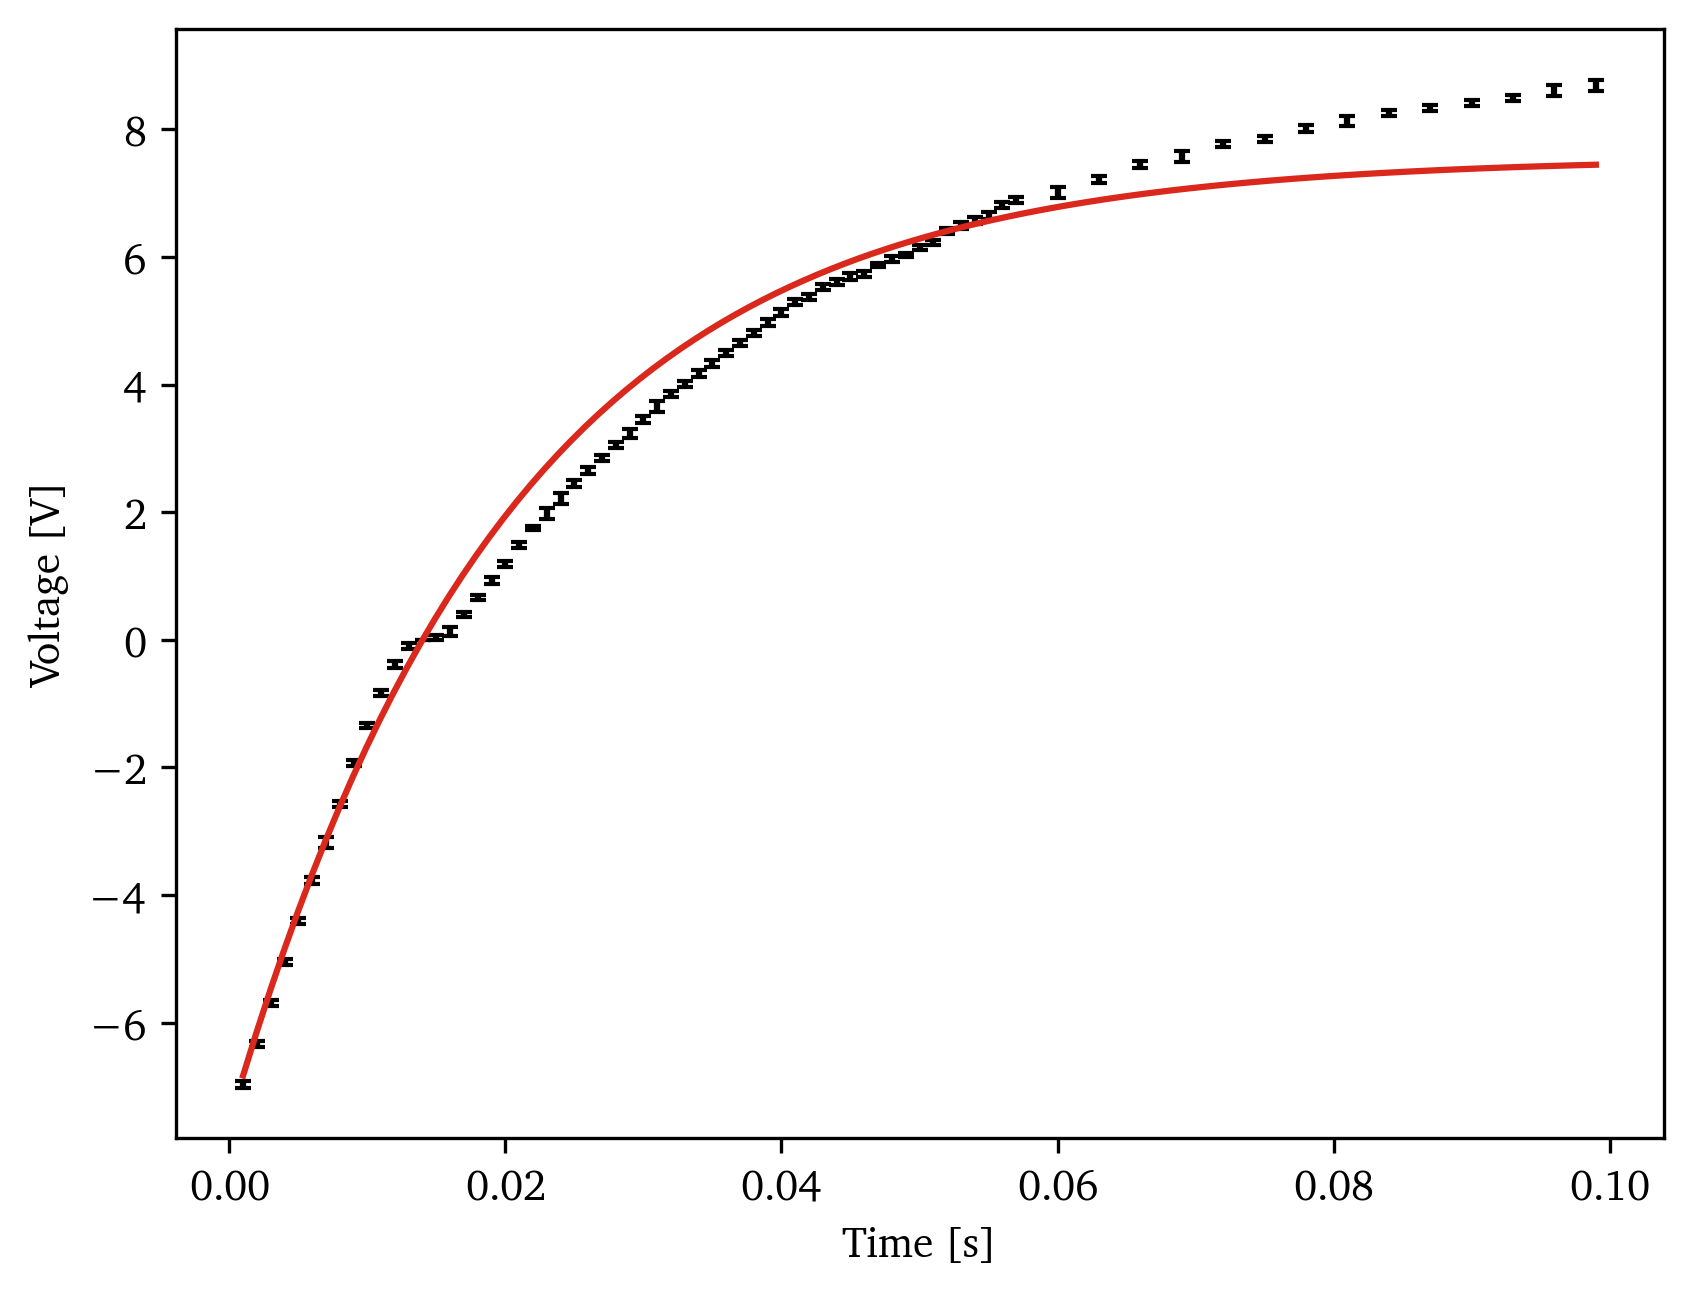

In [5]:
# Function to fit with.
def decay_model(t, V0, T1):
    return V0 * (1 - 2 * np.exp(-t / T1))

tdata = df['t']
Vdata = df['V'].apply(lambda V: V.nominal_value)
Vsigma = df['V'].apply(lambda V: max(V.std_dev, 1e-6))  # Replace 0 or near-zero std_dev with 1e-6

# Use curve_fit with sigma to account for errors
initial_guesses = [10, 0.01]
popt, pcov = curve_fit(decay_model, 
                               xdata=tdata, 
                               ydata=Vdata, 
                               sigma=Vsigma, 
                               p0=initial_guesses, 
                               absolute_sigma=True
                               )

# Extract fitted parameters and their uncertainties
V0_fitted, T1_fitted = popt
V0_error, T1_error = np.sqrt(np.diag(pcov))

print("Fitted V0:", V0_fitted, "+/-", V0_error)
print("Fitted T1:", T1_fitted, "+/-", T1_error)

# Plot data with error bars and fitted curve
t_fit = np.linspace(min(tdata), max(tdata), 100)
V_fit = decay_model(t_fit, V0_fitted, T1_fitted)

plt.plot(t_fit, V_fit, color='#da291c', zorder=10)
plt.errorbar(tdata, Vdata, yerr=Vsigma, fmt='none', label='Data with errors', color='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')

plt.show()

---
Spin–Lattice (Mineral Oil)

In [6]:
# Read CSV and make a new dataframe of ufloats for uncertainty handling.

df = pd.read_csv('/Users/rhillman/school/phys461/5-nmr/data/Spin–Lattice-Mineral Oil (15.268 MHz).csv')

df['V_uncertainty'] = np.abs(df['V_z_high (V)'] - df['V_z_low (V)']) / 2

df = pd.DataFrame({
    't': df['delta_t (s)'],
    'V': df.apply(lambda row: ufloat(row['V_z_avg (V)'], row['V_uncertainty']), axis=1)
})

minimum = get_minimum(df, 'V')
threshold = get_threshold(df, 'V', minimum)

df = remove_offset(df, minimum)
df = derectify(df, threshold, 'V')
df

,t,V
0,0.001,-9.15+/-0.08
1,0.002,-8.80+/-0.12
2,0.003,-8.35+/-0.08
3,0.004,-8.02+/-0.13
4,0.005,-7.66+/-0.10
...,...,...
66,0.087,8.22+/-0.10
67,0.090,8.36+/-0.15
68,0.093,8.60+/-0.12
69,0.096,8.75+/-0.16


Fitted V0: 10.012966354000243 +/- 0.025862035474038002
Fitted T1: 0.040395461145091335 +/- 5.820286452190912e-09


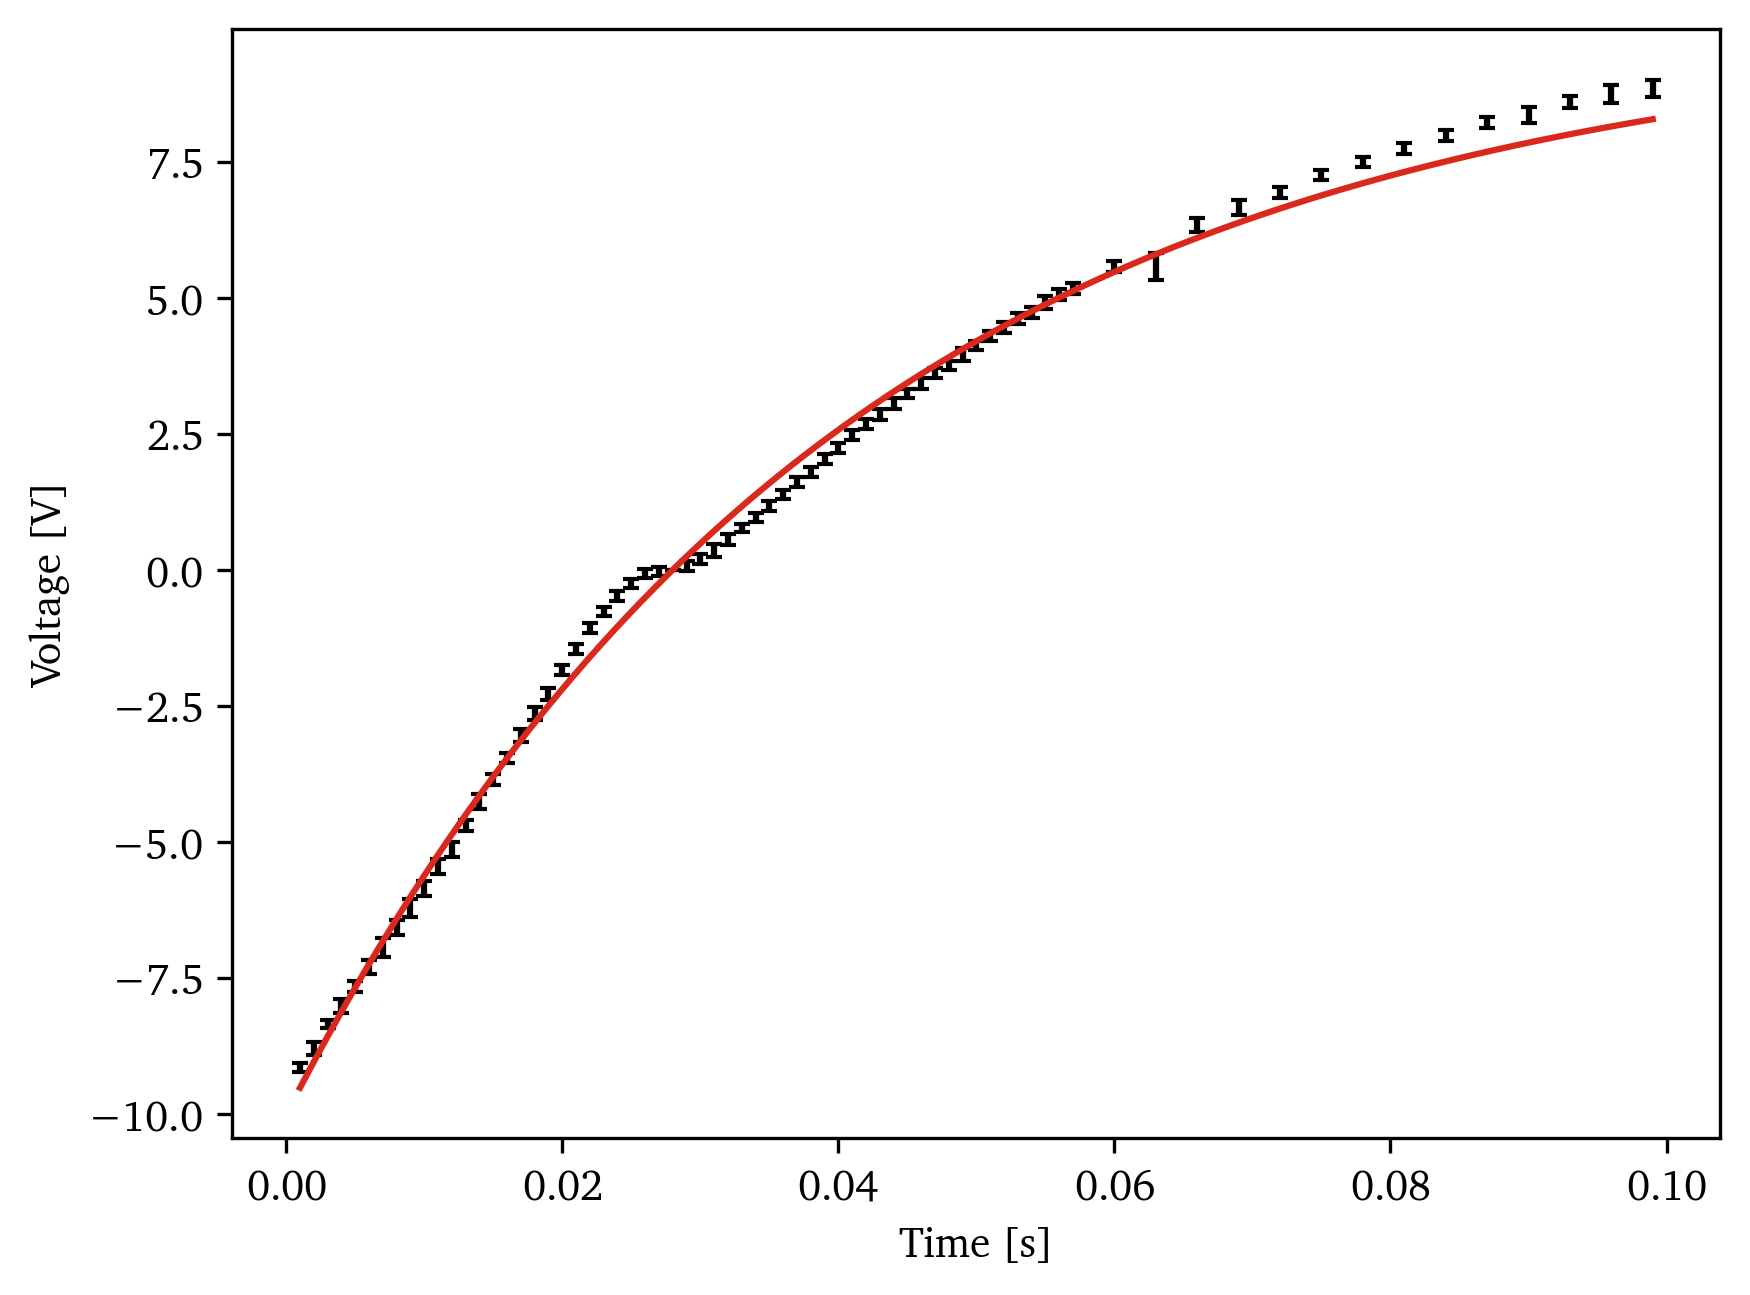

In [7]:
tdata = df['t']
Vdata = df['V'].apply(lambda V: V.nominal_value)
Vsigma = df['V'].apply(lambda V: max(V.std_dev, 1e-6))  # Replace 0 or near-zero std_dev with 1e-6

# Use curve_fit with sigma to account for errors
initial_guesses = [10, 0.01]
popt, pcov = curve_fit(decay_model, 
                               xdata=tdata, 
                               ydata=Vdata, 
                               sigma=Vsigma, 
                               p0=initial_guesses, 
                               absolute_sigma=True
                               )

# Extract fitted parameters and their uncertainties
V0_fitted, T1_fitted = popt
V0_error, T1_error = np.sqrt(np.diag(pcov))

print("Fitted V0:", V0_fitted, "+/-", V0_error)
print("Fitted T1:", T1_fitted, "+/-", T1_error)

# Plot data with error bars and fitted curve
t_fit = np.linspace(min(tdata), max(tdata), 100)
V_fit = decay_model(t_fit, V0_fitted, T1_fitted)

plt.plot(t_fit, V_fit, color='#da291c', zorder=10)
plt.errorbar(tdata, Vdata, yerr=Vsigma, fmt='none', label='Data with errors', color='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')

plt.show()

---
Spin–Spin (Glycerin)

Fitted V0: 17.721414888548708 +/- 0.03372375148853096
Fitted T2: 0.008545733631654253 +/- 1.5242818703604664e-05


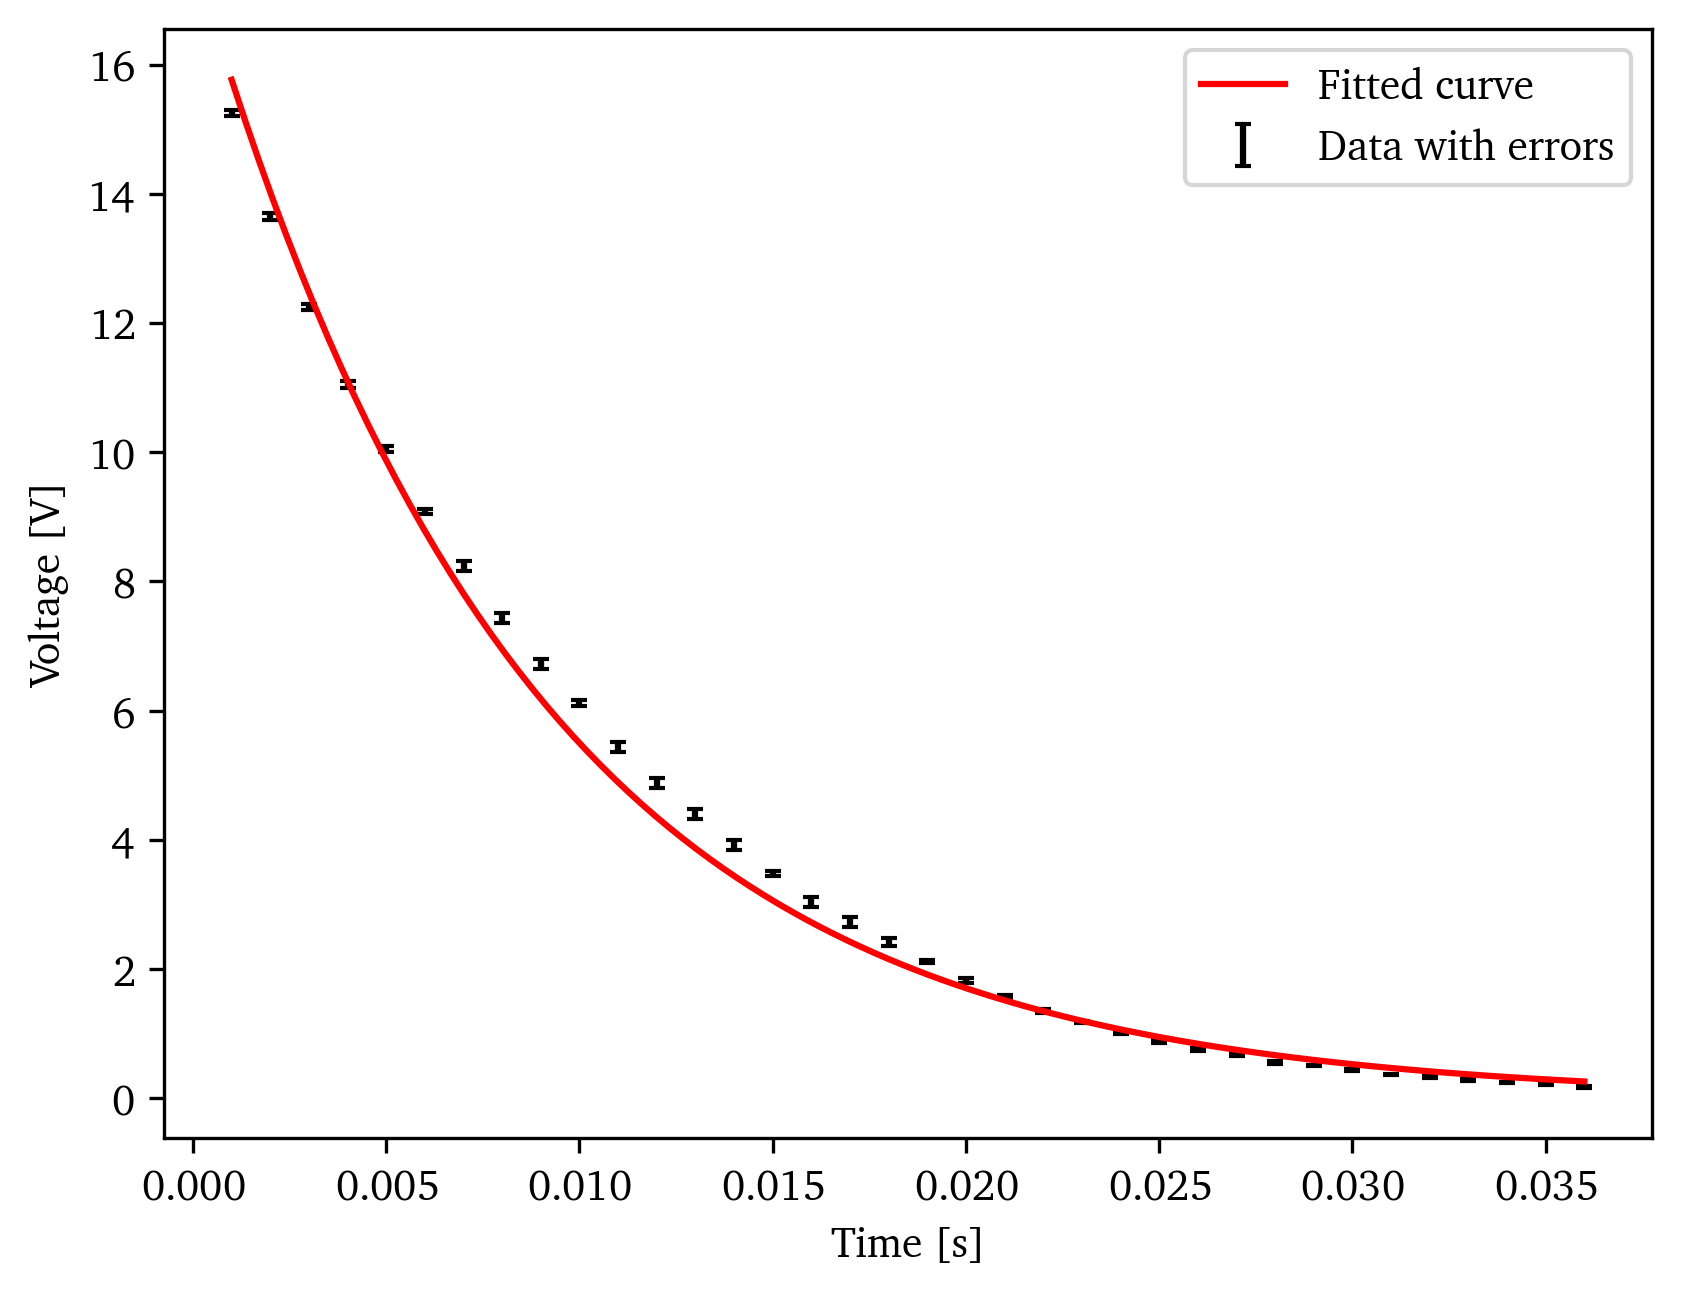

In [8]:
# Read CSV and make a new dataframe of ufloats for uncertainty handling.

df = pd.read_csv('/Users/rhillman/school/phys461/5-nmr/data/Spin–Spin-Glycerin.csv')

df['V_uncertainty'] = np.abs(df['V_echo_high'] - df['V_echo_low']) / 2

df = pd.DataFrame({
    't': df['delta_t'],
    'V': df.apply(lambda row: ufloat(row['V_echo_avg'], row['V_uncertainty']), axis=1)
})

# Define spin-spin relaxation model (exponential decay)
def spin_spin_decay_model(t, V0, T2):
    return V0 * np.exp(-t / T2)

# Prepare data as before
tdata = df['t']
Vdata = df['V'].apply(lambda V: V.nominal_value)
Vsigma = df['V'].apply(lambda V: max(V.std_dev, 1e-6))  # Avoid zero or near-zero std_dev

# Initial guesses for V0 and T2
initial_guesses = [17.72, 0.0085]

# Use curve_fit with sigma to account for errors
popt, pcov = curve_fit(spin_spin_decay_model, 
                       xdata=tdata, 
                       ydata=Vdata, 
                       sigma=Vsigma, 
                       p0=initial_guesses, 
                       absolute_sigma=True)

# Extract fitted parameters and their uncertainties
V0_fitted, T2_fitted = popt
V0_error, T2_error = np.sqrt(np.diag(pcov))

print("Fitted V0:", V0_fitted, "+/-", V0_error)
print("Fitted T2:", T2_fitted, "+/-", T2_error)

# Plot data with error bars and fitted curve
t_fit = np.linspace(min(tdata), max(tdata), 100)
V_fit = spin_spin_decay_model(t_fit, V0_fitted, T2_fitted)

plt.plot(t_fit, V_fit, label='Fitted curve', color='red', zorder=10)
plt.errorbar(tdata, Vdata, yerr=Vsigma, fmt='none', label='Data with errors', color='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.show()

---
Spin–Spin (Mineral Oil)

Fitted V0: 19.837611414588395 +/- 0.08432481151868503
Fitted T2: 0.021566020484140063 +/- 0.00015254625342942565


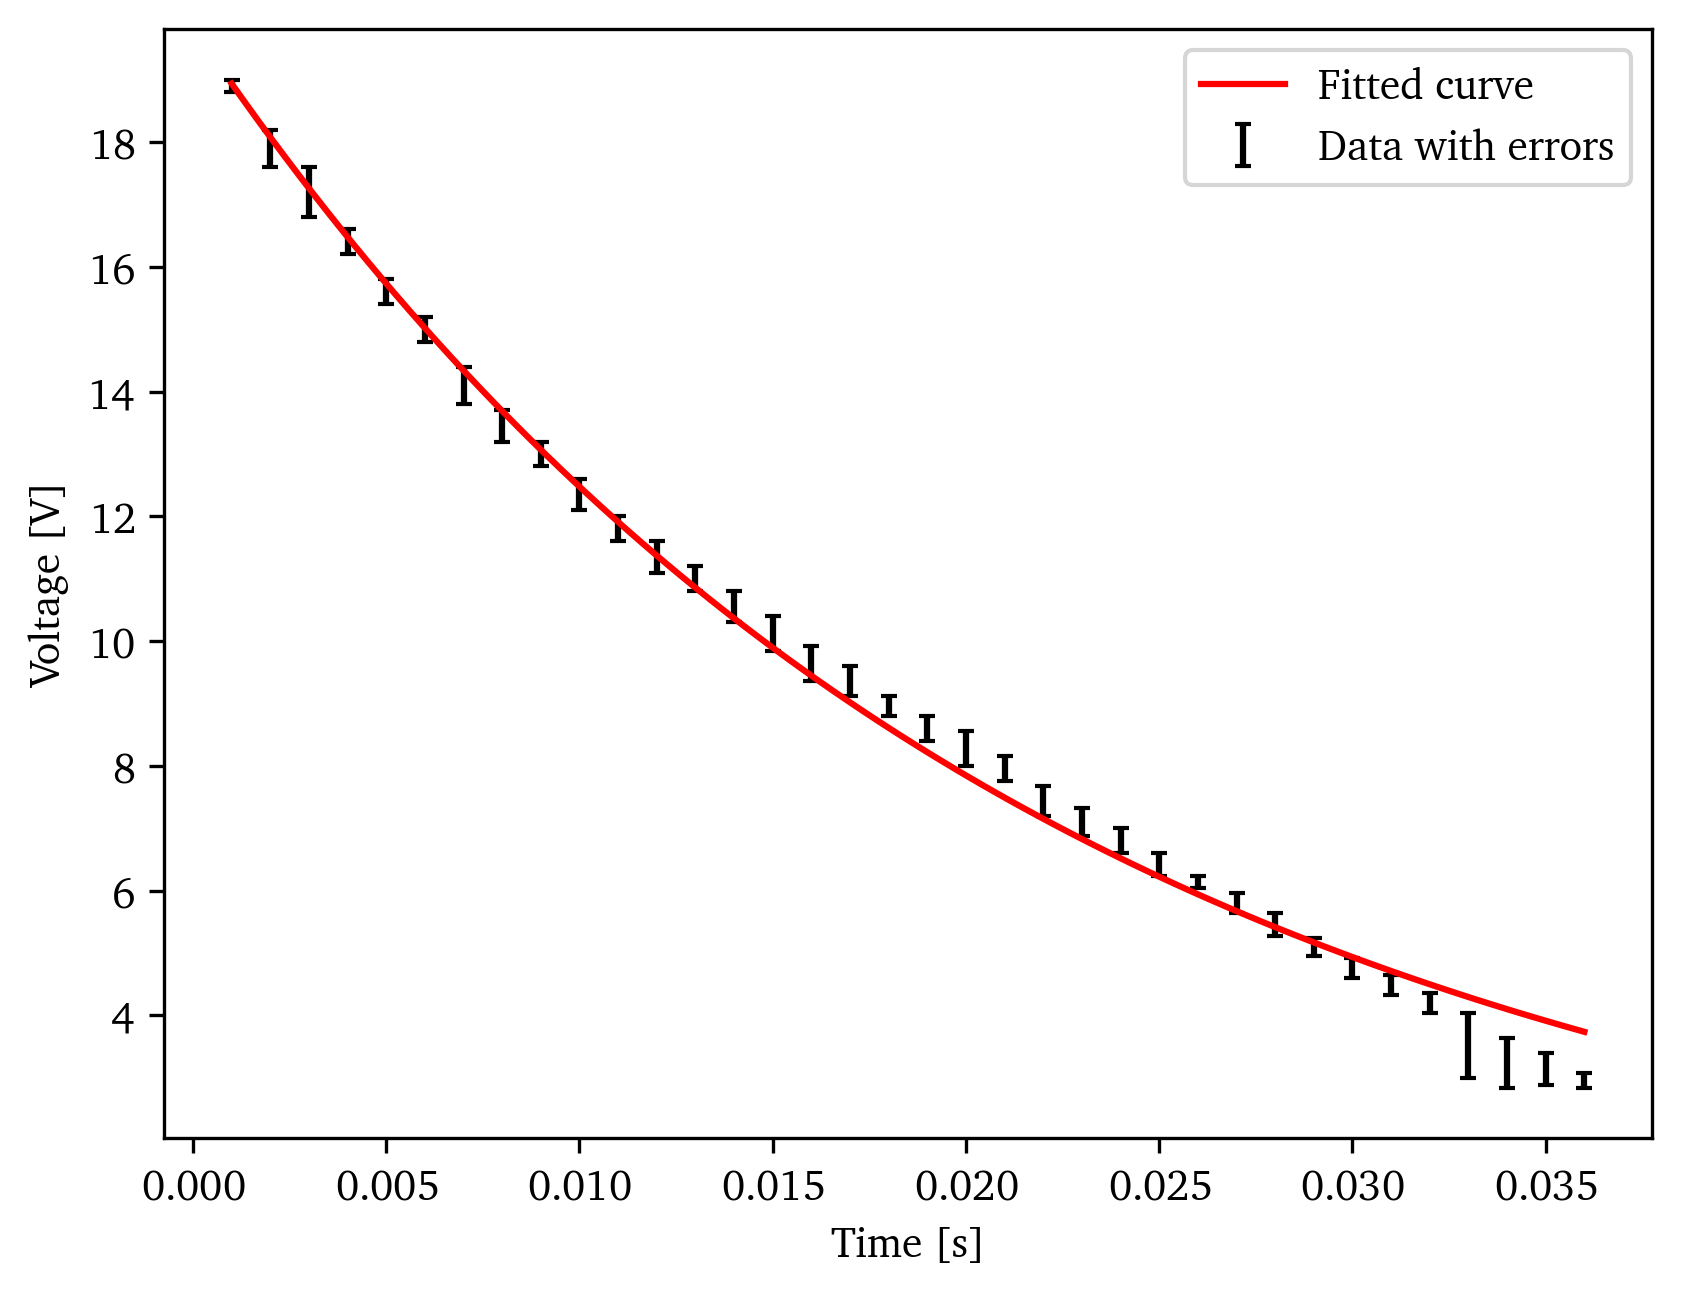

In [9]:
# Read CSV and make a new dataframe of ufloats for uncertainty handling.

df = pd.read_csv('/Users/rhillman/school/phys461/5-nmr/data/Spin–Spin-Mineral Oil.csv')

df['V_uncertainty'] = np.abs(df['V_echo_high'] - df['V_echo_low']) / 2

df = pd.DataFrame({
    't': df['delta_t'],
    'V': df.apply(lambda row: ufloat(row['V_echo_avg'], row['V_uncertainty']), axis=1)
})

# Define spin-spin relaxation model (exponential decay)
def spin_spin_decay_model(t, V0, T2):
    return V0 * np.exp(-t / T2)

# Prepare data as before
tdata = df['t']
Vdata = df['V'].apply(lambda V: V.nominal_value)
Vsigma = df['V'].apply(lambda V: max(V.std_dev, 1e-6))  # Avoid zero or near-zero std_dev

# Initial guesses for V0 and T2
initial_guesses = [19.83, 0.0215]

# Use curve_fit with sigma to account for errors
popt, pcov = curve_fit(spin_spin_decay_model, 
                       xdata=tdata, 
                       ydata=Vdata, 
                       sigma=Vsigma, 
                       p0=initial_guesses, 
                       absolute_sigma=True)

# Extract fitted parameters and their uncertainties
V0_fitted, T2_fitted = popt
V0_error, T2_error = np.sqrt(np.diag(pcov))

print("Fitted V0:", V0_fitted, "+/-", V0_error)
print("Fitted T2:", T2_fitted, "+/-", T2_error)

# Plot data with error bars and fitted curve
t_fit = np.linspace(min(tdata), max(tdata), 100)
V_fit = spin_spin_decay_model(t_fit, V0_fitted, T2_fitted)

plt.plot(t_fit, V_fit, label='Fitted curve', color='red', zorder=10)
plt.errorbar(tdata, Vdata, yerr=Vsigma, fmt='none', label='Data with errors', color='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.show()